# Logistic Regression (Gradient Ascent)

We fit a binary classification model by **maximizing** the log-likelihood $\ell(\theta)$ using **gradient ascent**. The hypothesis is $h(X) = g(\theta^T X)$ where $g$ is the sigmoid function.

## Imports

We use **NumPy** for array operations and the function `load_classification_data` from `utils` to load the design matrix $X$ and binary labels $y$.

In [1]:
import numpy as np
from utils import load_classification_data

### Functions for logistic regression

### Sigmoid

The sigmoid function maps any real number to $(0, 1)$:

$$
g(z) = \frac{1}{1 + e\^{-z}}
$$

The code returns `1 / (1 + np.exp(-z))`.

In [2]:
def g(z):
    'Sigmoid function; maps real numbers to (0, 1)'
    return 1 / (1 + np.exp(-z))

### Hypothesis

The logistic model predicts a probability: $h(x^{(i)}) = g(\theta^T x^{(i)})$. In matrix form, with $X$ of shape $(n+1) \times m$ (each column is a sample, first row is ones for the intercept) and $\theta$ of shape $(n+1) \times 1$:

$$
h_\theta(X) = g(\theta^T X) \quad \Rightarrow \quad \text{shape } (1 \times m)
$$

The code returns `g(np.dot(np.transpose(theta), X))`.

In [3]:
def h(X, theta):
    'Hypothesis for logistic regression; returns a matrix of shape (1, m)'
    return g(np.dot(np.transpose(theta), X))

### Log-likelihood

We maximize the average log-likelihood over the $m$ samples:

$$
\ell(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ y^{(i)} \log h(x^{(i)}) + (1 - y^{(i)}) \log(1 - h(x^{(i)})) \right]
$$

The code uses `(1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))` with a small clip to avoid $\log 0$. We use $m = X.shape[1]$ inside the function.

In [4]:
def l(X, y, theta):
    'Log-likelihood for logistic regression; returns a scalar'
    m = X.shape[1]
    h_val = h(X, theta)
    # Clip to avoid log(0); use small epsilon
    eps = 1e-15
    h_val = np.clip(h_val, eps, 1 - eps)
    return (1 / m) * np.sum(y * np.log(h_val) + (1 - y) * np.log(1 - h_val))

### Gradient of the log-likelihood

The gradient of $\ell$ with respect to $\theta$ (column vector of shape $(n+1) \times 1$) is:

$$
\nabla \ell(\theta) = \frac{1}{m} X \, (y - h_\theta(X))^T
$$

In code we compute $(y - h)$ (shape $1 \times m$), multiply by $X^T$ (shape $m \times (n+1)$), and reshape to $(n+1) \times 1$: `(1/m) * np.dot((y - h(X, theta)), np.transpose(X)).reshape((-1, 1))`.

In [5]:
def dl(X, y, theta):
    'Gradient of the log-likelihood with respect to theta; returns shape (n+1, 1)'
    m = X.shape[1]
    return (1 / m) * np.dot((y - h(X, theta)), np.transpose(X)).reshape((-1, 1))

## Load and preprocess the data

`load_classification_data()` returns the design matrix $X$ (e.g. shape $n \times m$) and binary labels $y$ (shape $1 \times m$). We normalize each feature (z-score) and prepend a row of ones so the first component of $\theta$ is the intercept; then $X$ has shape $(n+1) \times m$.

In [6]:
X, y = load_classification_data()

m = X.shape[1]
n = X.shape[0]

# Normalize features (z-score per feature)
X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

# Prepend a row of ones for the intercept
unos = np.ones((1, m))
X = np.append(unos, X, axis=0)

print(f'X: {X.shape}, y: {y.shape}')

X: (31, 569), y: (1, 569)


## Data exploration

Inspect the shape of $X$ and $y$, and the mean and standard deviation of each row of $X$ (first row should be 1 and 0 for the bias row after normalization).

In [7]:
print(f'X.shape: {X.shape}, y.shape: {y.shape}')
print(f'Mean per row (first row ~ 1): {np.mean(X, axis=1)[:3]}...')
print(f'Std per row (first row ~ 0): {np.std(X, axis=1)[:3]}...')

X.shape: (31, 569), y.shape: (1, 569)
Mean per row (first row ~ 1): [ 1.00000000e+00 -3.16286735e-15 -6.53060890e-15]...
Std per row (first row ~ 0): [0. 1. 1.]...


## Hyperparameters

$\alpha$ = learning rate for gradient ascent; number of iterations.

In [8]:
alpha = 0.04
iteraciones = 2000

## Initialize $\theta$

Random initialization, shape $(n+1) \times 1$ to match the rows of $X$.

In [9]:
theta = np.random.random((X.shape[0], 1))

## Training log and initial log-likelihood

We will record $\ell(\theta)$ at each iteration. Compute and print the initial log-likelihood.

In [10]:
registro_l = []
l_init = l(X, y, theta)
print(f'Initial log-likelihood: {l_init}')
registro_l.append(l_init)

Initial log-likelihood: -6.4629544856068675


## Gradient ascent loop

At each iteration we compute the gradient $\nabla \ell(\theta)$ and update:

$$
\theta \leftarrow \theta + \alpha \, \nabla \ell(\theta)
$$

We record $\ell(\theta)$ after each update to plot the learning curve.

In [11]:
for i in range(iteraciones):
    dlikelihood = dl(X, y, theta)
    theta = theta + alpha * dlikelihood
    registro_l.append(l(X, y, theta))

print(f'Final log-likelihood: {l(X, y, theta)}')

Final log-likelihood: -0.065708165570433


## Learning curve

Plot $\ell(\theta)$ vs iteration index to check that the log-likelihood increases (convergence of gradient ascent).

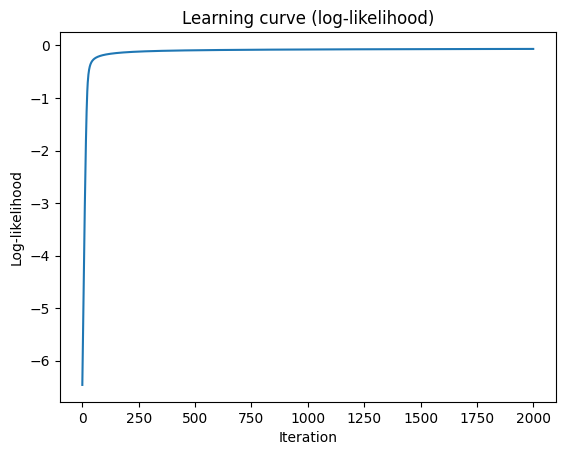

In [12]:
import matplotlib.pyplot as plt

it = list(range(iteraciones + 1))
plt.plot(it, registro_l)
plt.title('Learning curve (log-likelihood)')
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.show()

## Making a prediction

For a new input $x_{\text{new}}$ (with bias term as first component), we compute $\hat{p} = h(x_{\text{new}})$. We classify as class 1 if $\hat{p} \geq 0.5$, else class 0.

In [13]:
# Use one sample from X as example (already has bias)
x_new = X[:, 0:1]
p_pred = h(x_new, theta)
class_pred = 1 if p_pred[0, 0] >= 0.5 else 0
print(f'Predicted probability: {p_pred[0, 0]:.4f}')
print(f'Predicted class: {class_pred}')
print(f'True label for this sample: {y[0, 0]}')

Predicted probability: 0.0000
Predicted class: 0
True label for this sample: 0
